# PPO

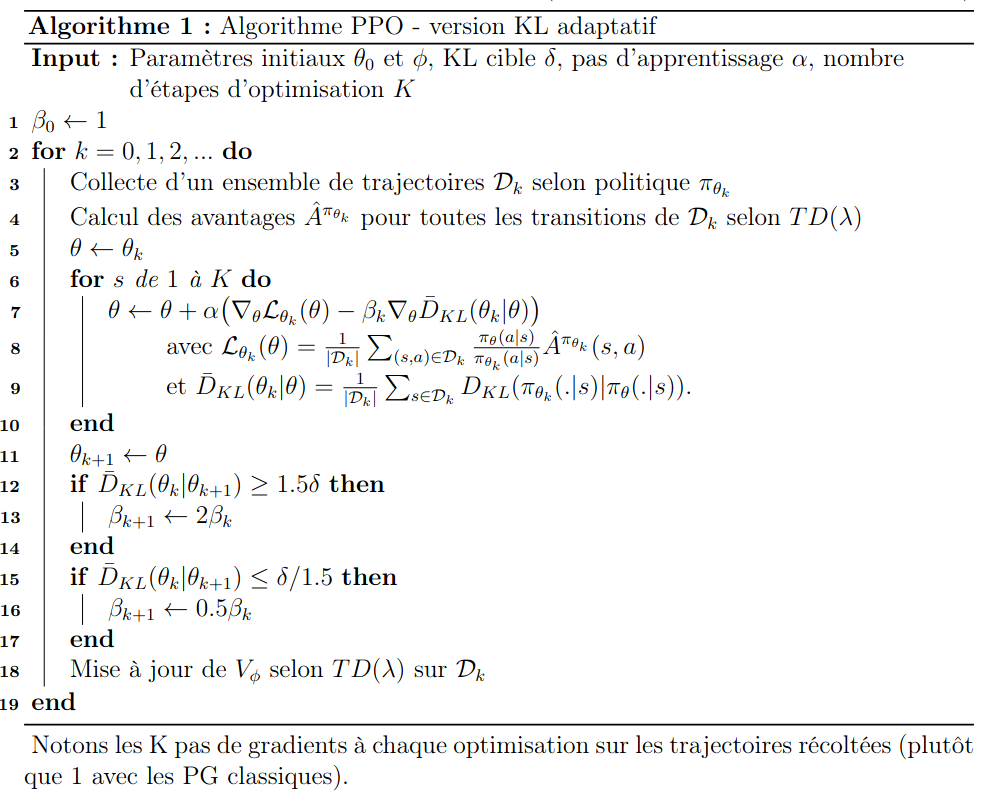

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm

In [26]:
class NetworkActor(nn.Module) : 
    
    def __init__(self,
                 nb_obs,
                 nb_actions,
                 nb_neurons
                ) :
        super().__init__()
        self.nb_obs = nb_obs
        self.nb_actions = nb_actions
        self.nb_neurons = nb_neurons
        
        self.net = nn.Sequential(
            nn.Linear(self.nb_obs,self.nb_neurons),
            nn.Tanh(),
            nn.Linear(self.nb_neurons,self.nb_neurons),
            nn.Tanh(),
            nn.Linear(self.nb_neurons,self.nb_actions),
            nn.Softmax()
        )
        
    def forward(self,x) :
        return self.net(x)

In [27]:
class NetworkCritic(nn.Module) : 
    
    def __init__(self,
                 nb_obs,
                 nb_actions,
                 nb_neurons
                ) :
        super().__init__()
        self.nb_obs = nb_obs
        self.nb_actions = nb_actions
        self.nb_neurons = nb_neurons
        
        
        self.net = nn.Sequential(
            nn.Linear(self.nb_obs,self.nb_neurons),
            nn.Tanh(),
            nn.Linear(self.nb_neurons,self.nb_neurons),
            nn.Tanh(),
            nn.Linear(self.nb_neurons,1),
            
        )
        
    def forward(self,x) :
        return self.net(x)

In [35]:
def kl_div(p, q):
    p =  torch.distributions.utils.clamp_probs(p)
    q =  torch.distributions.utils.clamp_probs(q)
    return (p * (torch.log(p) - torch.log(q))).sum(-1)

class AgentPPO :
    
    def __init__(self,
                kl_value : float,
                discount_factor : float,
                learning_rate : float,
                timesteps_per_batch : int,
                max_timesteps_per_episode : int,
                nb_eval : int,
                test_frequency : float,
                network_actor : NetworkActor,
                network_critic : NetworkCritic,
                optimizer_actor,
                optimizer_critic,
                env
                ) -> None:
        
        self.kl_value = kl_value
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.timesteps_per_batch = timesteps_per_batch
        self.max_timesteps_per_episode = max_timesteps_per_episode
        self.nb_eval = nb_eval
        self.test_frequency = test_frequency
        self.network_actor = network_actor
        self.network_critic = network_critic
        self.optimizer_actor = optimizer_actor
        self.optimizer_critic = optimizer_critic
        self.env = env
        
        self.beta = 1.0
        
    def collect(self):
        batch_episode = list()
        batch_experiences = list()
        
        size_batch = 0
        
        while size_batch < self.timesteps_per_batch :
            i = 0
            done = False
            state = self.env.reset()
            while not done or i < self.max_timesteps_per_episode :
                state_t = torch.as_tensor(state , dtype=torch.float32)
                best_action = np.random.choice(a=np.arange(2),p=self.network_actor(state_t).detach().numpy().reshape(2)) # torch.argmax(self.network_actor(state_t)).item()
                new_state,reward,done,_ = self.env.step(best_action)
                experience = (state,reward,done,new_state,best_action)
                batch_experiences.append(experience)
                state = new_state
                i += 1
                size_batch += 1
                
            batch_episode.append(batch_experiences)
            batch_experiences = list()
                
        return batch_episode
            
    
    def compute_advantage(self,batch_episode) :
        batch_advantage = list()
        for episode in batch_episode: 
            
            discounted_reward = 0
            
            for (state,reward,done,new_state,best_action) in reversed(episode) :
                
                state_t = torch.as_tensor(state , dtype=torch.float32)
                new_state_t = torch.as_tensor(new_state , dtype=torch.float32)
                
                discounted_reward = reward + discounted_reward * self.discount_factor
                advantage = reward + self.discount_factor * (1 - done) * self.network_critic(new_state_t) - self.network_critic(state_t)
                # advantage = (discounted_reward - self.network_critic(state_t))
                advantage = advantage.detach().numpy()
                
                new_data = (state,advantage,discounted_reward,new_state,best_action,reward,done)
                batch_advantage.append(new_data)
                
        return batch_advantage
    
    def step(self) : 
        batch_episode = self.collect()
        batch_advantage = self.compute_advantage(batch_episode)

        states = np.asarray([exp[0] for exp in batch_advantage],dtype=np.float32)
        states_t = torch.as_tensor(states, dtype=torch.float32)
        
        advantages = np.asarray([exp[1] for exp in batch_advantage],dtype=np.float32)
        advantages_t = torch.as_tensor(advantages , dtype=torch.float32)
        
        advantages_t = (advantages_t - advantages_t.mean()) / advantages_t.std()
        
        rtgs = np.asarray([rtg[2] for rtg in batch_advantage],dtype=np.float32)
        rtgs_t = torch.as_tensor(rtgs, dtype=torch.float32)
        
        actions = np.asarray([exp[4] for exp in batch_advantage],dtype=np.int64)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(1)
        
        first_proba = self.network_actor(states_t).detach()
        first_distrib = torch.gather(input=first_proba,dim=1,index=actions_t).detach()
        
        for s in range(5) :
            
            # Surrogate
            surrogate_loss = (torch.gather(input=torch.distributions.utils.clamp_probs(self.network_actor(states_t)),dim=1,index=actions_t) / first_distrib) * advantages_t.detach()# torch.gather(input=old_network_actor(states_t).detach(),dim=1,index=actions_t)) * advantages_t
            surrogate_loss = torch.mean(surrogate_loss)

            # kullback_leibler
            kullback_leibler = kl_div(self.network_actor(states_t),first_proba) # kl_div(old_network_actor(states_t), self.network_actor(states_t))
            kullback_leibler = torch.mean(kullback_leibler)

            loss_actor = - (surrogate_loss - (self.beta * kullback_leibler) )

            self.optimizer_actor.zero_grad()
            loss_actor.backward()
            self.optimizer_actor.step()
        
        dkl = kl_div(self.network_actor(states_t),first_proba)
        dkl = torch.mean(dkl)
        
        if dkl >= 1.5 * self.kl_value :
            self.beta = 2.0 * self.beta
            
        if dkl <= self.kl_value / 1.5 :
            self.beta = 0.5 * self.beta
            
        V = self.network_critic(states_t)
        
        # td0 = (rewards_t + self.discount_factor * (1-dones_t) * self.network_critic(new_states_t).squeeze()).float().squeeze().detach()
            
        mse = torch.nn.MSELoss()
        loss_critic = mse(rtgs_t.unsqueeze(1),V)
        
        
        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()
        
        
    def test(self) :
        """
        retourne la reward cumulée de l'episode
        """
        state = self.env.reset()
        cum_rew = 0
        done = False
        while not done :
            state_t = torch.as_tensor(state, dtype=torch.float32)
            best_action = np.random.choice(a=np.arange(2),p=self.network_actor(state_t).detach().numpy().reshape(2)) # torch.argmax(self.network_actor(state_t)).item()
            new_state,reward,done,_ = self.env.step(best_action)
            cum_rew += reward
            state = new_state
        return cum_rew
        

    def learning(self): 
        list_rewards = list()
        for i in tqdm(range(self.nb_eval)):
            self.step()
            if i % self.test_frequency == 0:
                reward = self.test()
                list_rewards.append(reward)
                # print(f"iteration : {i} - test reward : {reward} - beta : {self.beta}")
        return list_rewards

100%|███████████████████████████████████████| 1000/1000 [07:21<00:00,  2.27it/s]


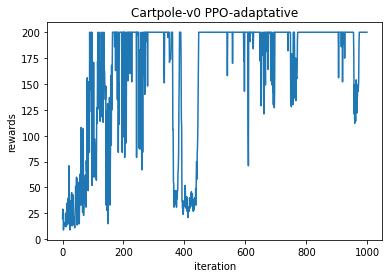

In [36]:
env = gym.make("CartPole-v0")

init_network_actor = NetworkActor(
    nb_obs = 4,
    nb_actions = 2,
    nb_neurons = 30
)

init_network_critic = NetworkCritic(
    nb_obs = 4,
    nb_actions = 2,
    nb_neurons = 30
)

optimizer_actor = torch.optim.Adam(init_network_actor.parameters(), lr=0.001)
optimizer_critic = torch.optim.Adam(init_network_critic.parameters(), lr=0.003)

agentPPO = AgentPPO(
    kl_value = 0.05,
    discount_factor = 0.99,
    learning_rate = 0.005,
    timesteps_per_batch =  1000,# 4800,
    max_timesteps_per_episode = 500,# 1600,
    nb_eval = 1000,
    test_frequency = 1,
    network_actor = init_network_actor,
    network_critic = init_network_critic,
    optimizer_actor = optimizer_actor,
    optimizer_critic = optimizer_critic,
    env = env
)


list_rewards_adaptative = agentPPO.learning()

plt.figure()
plt.title("Cartpole-v0 PPO-adaptative")
plt.xlabel("iteration")
plt.ylabel("rewards")
plt.plot(list_rewards_adaptative)
plt.show()

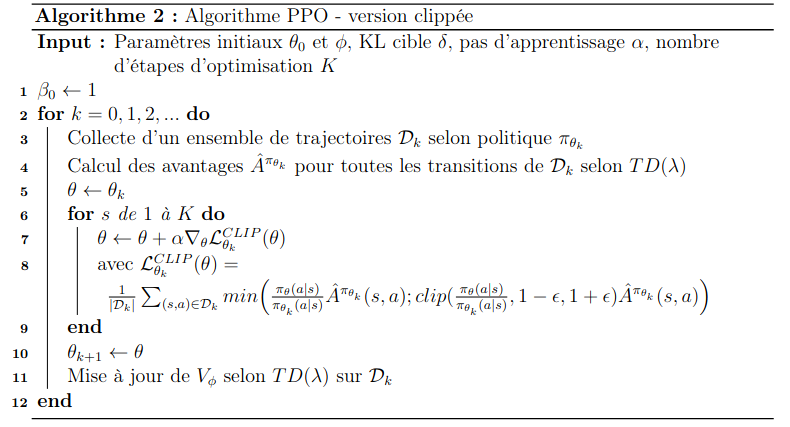

In [37]:
class AgentPPO_clip :
    
    def __init__(self,
                kl_value : float,
                K : int,
                eps : float,
                discount_factor : float,
                learning_rate : float,
                timesteps_per_batch : int,
                max_timesteps_per_episode : int,
                nb_eval : int,
                test_frequency : float,
                frequency_update_critic : float,
                network_actor : NetworkActor,
                network_critic : NetworkCritic,
                optimizer_actor,
                optimizer_critic,
                env
                ) -> None:
        
        self.kl_value = kl_value
        self.K = K
        self.eps = eps
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.timesteps_per_batch = timesteps_per_batch
        self.max_timesteps_per_episode = max_timesteps_per_episode
        self.nb_eval = nb_eval
        self.test_frequency = test_frequency
        self.frequency_update_critic = frequency_update_critic
        self.network_actor = network_actor
        self.network_critic = network_critic
        self.optimizer_actor = optimizer_actor
        self.optimizer_critic = optimizer_critic
        self.env = env
        
        self.beta = 1.0
        
    def collect(self):
        batch_episode = list()
        batch_experiences = list()
        
        size_batch = 0
        
        while size_batch < self.timesteps_per_batch :
            i = 0
            done = False
            state = self.env.reset()
            while not done or i < self.max_timesteps_per_episode :
                state_t = torch.as_tensor(state , dtype=torch.float32)
                best_action = np.random.choice(a=np.arange(2),p=self.network_actor(state_t).detach().numpy().reshape(2)) # torch.argmax(self.network_actor(state_t)).item()
                new_state,reward,done,_ = self.env.step(best_action)
                experience = (state,reward,done,new_state,best_action)
                batch_experiences.append(experience)
                state = new_state
                i += 1
                size_batch += 1
                
            batch_episode.append(batch_experiences)
            batch_experiences = list()
                
        return batch_episode
            
    
    def compute_advantage(self,batch_episode) :
        batch_advantage = list()
        for episode in batch_episode: 
            
            discounted_reward = 0
            
            for (state,reward,done,new_state,best_action) in reversed(episode) :
                
                state_t = torch.as_tensor(state , dtype=torch.float32)
                new_state_t = torch.as_tensor(new_state , dtype=torch.float32)
                
                discounted_reward = reward + discounted_reward * self.discount_factor
                advantage = reward + self.discount_factor * (1 - done) * self.network_critic(new_state_t) - self.network_critic(state_t)
                # advantage = (discounted_reward - self.network_critic(state_t))
                advantage = advantage.detach().numpy()
                
                new_data = (state,advantage,discounted_reward,new_state,best_action,reward,done)
                batch_advantage.append(new_data)
                
        return batch_advantage
    
    def step(self) : 
        batch_episode = self.collect()
        batch_advantage = self.compute_advantage(batch_episode)

        states = np.asarray([exp[0] for exp in batch_advantage],dtype=np.float32)
        states_t = torch.as_tensor(states, dtype=torch.float32)
        
        advantages = np.asarray([exp[1] for exp in batch_advantage],dtype=np.float32)
        advantages_t = torch.as_tensor(advantages , dtype=torch.float32)
        
        advantages_t = (advantages_t - advantages_t.mean()) / advantages_t.std()
        
        rtgs = np.asarray([rtg[2] for rtg in batch_advantage],dtype=np.float32)
        rtgs_t = torch.as_tensor(rtgs, dtype=torch.float32)
        
        actions = np.asarray([exp[4] for exp in batch_advantage],dtype=np.int64)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(1)
        
        first_proba = self.network_actor(states_t).detach()
        first_distrib = torch.gather(input=first_proba,dim=1,index=actions_t).detach()
        
        for _ in range(self.K) :
            
            val1 = (torch.gather(input=torch.distributions.utils.clamp_probs(self.network_actor(states_t)),dim=1,index=actions_t) / first_distrib) * advantages_t.detach()# torch.gather(input=old_network_actor(states_t).detach(),dim=1,index=actions_t)) * advantages_t
            val1 = torch.mean(val1)
             
            ratio = (torch.gather(input=torch.distributions.utils.clamp_probs(self.network_actor(states_t)),dim=1,index=actions_t) / first_distrib)
            val2 = torch.clip(torch.mean(ratio), min=(1-self.eps), max=(1+self.eps)) * torch.mean(advantages_t.detach())
           
            loss_actor = - torch.min(val1,val2)

            self.optimizer_actor.zero_grad()
            loss_actor.backward()
            self.optimizer_actor.step()
        
        if self.iteration % self.frequency_update_critic == 0 : 
        
            V = self.network_critic(states_t)

            mse = torch.nn.MSELoss()
            loss_critic = mse(rtgs_t.unsqueeze(1),V)

            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            self.optimizer_critic.step()
        
        
    def test(self) :
        """
        retourne la reward cumulée de l'episode
        """
        state = self.env.reset()
        cum_rew = 0
        done = False
        while not done :
            state_t = torch.as_tensor(state, dtype=torch.float32)
            best_action = np.random.choice(a=np.arange(2),p=self.network_actor(state_t).detach().numpy().reshape(2)) # torch.argmax(self.network_actor(state_t)).item()
            new_state,reward,done,_ = self.env.step(best_action)
            cum_rew += reward
            state = new_state
        return cum_rew
        

    def learning(self): 
        self.iteration = 0
        list_rewards = list()
        for i in tqdm(range(self.nb_eval)):
            self.iteration = i
            self.step()
            if i % self.test_frequency == 0:
                reward = self.test()
                list_rewards.append(reward)
                # print(f"iteration : {i} - test reward : {reward} - beta : {self.beta}")
        return list_rewards

100%|███████████████████████████████████████| 1000/1000 [07:31<00:00,  2.21it/s]


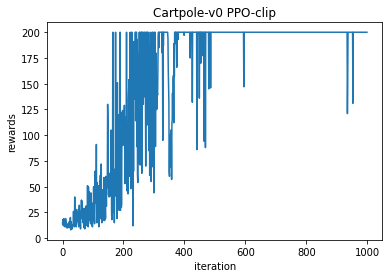

In [38]:
env = gym.make("CartPole-v0")

init_network_actor = NetworkActor(
    nb_obs = 4,
    nb_actions = 2,
    nb_neurons = 30
)

init_network_critic = NetworkCritic(
    nb_obs = 4,
    nb_actions = 2,
    nb_neurons = 30
)

optimizer_actor = torch.optim.Adam(init_network_actor.parameters(), lr=0.001)
optimizer_critic = torch.optim.Adam(init_network_critic.parameters(), lr=0.003)

agentPPO_clip = AgentPPO_clip(
    kl_value = 0.05,
    K = 5,
    eps = 0.2,
    discount_factor = 0.99,
    learning_rate = 0.005,
    timesteps_per_batch =  1000,# 4800,
    max_timesteps_per_episode = 500,# 1600,
    nb_eval = 1000,
    test_frequency = 1,
    frequency_update_critic = 1,
    network_actor = init_network_actor,
    network_critic = init_network_critic,
    optimizer_actor = optimizer_actor,
    optimizer_critic = optimizer_critic,
    env = env
)


list_rewards_clip = agentPPO_clip.learning()

plt.figure()
plt.title("Cartpole-v0 PPO-clip")
plt.xlabel("iteration")
plt.ylabel("rewards")
plt.plot(list_rewards_clip)
plt.show()

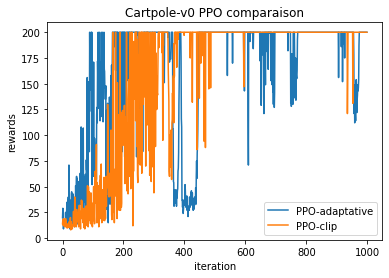

In [40]:
plt.figure()
plt.title("Cartpole-v0 PPO comparaison")
plt.xlabel("iteration")
plt.ylabel("rewards")
plt.plot(list_rewards_adaptative,label="PPO-adaptative")
plt.plot(list_rewards_clip,label="PPO-clip")
plt.legend()
plt.show()

# DDPG

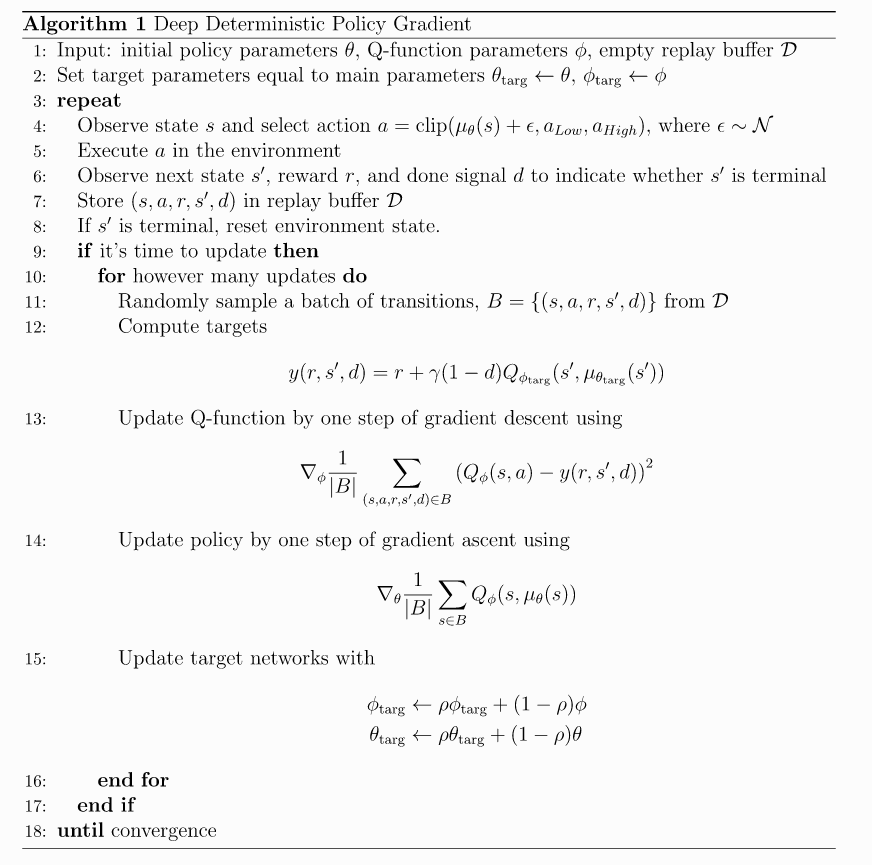

In [51]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
from collections import deque
from tqdm import tqdm

env = gym.make("Walker2d-v2")

NB_ITERATION = 1e6

REPLAY_BUFFER_SIZE = 10000
NB_ITERATION = 10000
FREQUENCY_UPDATE = 4
FREQUENCY_TEST = 100
BATCH_SIZE = 64
DISCOUNT_FACTOR = 0.99
TAU = 0.001
actor_learning_rate = 0.0001
critic_learning_rate = 0.001

list_res = []
nb_actions = 6
nb_observations = 17

class PolicyNetwork(nn.Module) : 

    def __init__(self,
                nb_actions,
                nb_observations,
                nb_neurons=40
                ) -> None:

        super().__init__()

        self.nb_actions = nb_actions
        self.nb_observations = nb_observations

        self.net = nn.Sequential(
            nn.Linear(nb_observations,50),
            nn.ReLU(),
            nn.Linear(50,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,nb_actions),
            nn.Tanh()
        )

    def forward(self,x) :
        return self.net(x)


class CriticNetwork(nn.Module) :

    def __init__(self,
                nb_actions,
                nb_observations,
                nb_neurons=600
                ) -> None:

        super().__init__()

        self.nb_actions = nb_actions
        self.nb_observations = nb_observations

        self.net = nn.Sequential(
            nn.Linear(nb_observations + nb_actions,50),
            nn.ReLU(),
            nn.Linear(50,20),
            nn.ReLU(),
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,1),
        )

    def forward(self,x) :
        return self.net(x)


replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

policy_network = PolicyNetwork(nb_actions,nb_observations,200)
critic_network = CriticNetwork(nb_actions,nb_observations,200)

policy_network_target = PolicyNetwork(nb_actions,nb_observations,200)
critic_network_target = CriticNetwork(nb_actions,nb_observations,200)

policy_network_target.load_state_dict(policy_network.state_dict())
critic_network_target.load_state_dict(critic_network.state_dict())


optimizer_policy = torch.optim.Adam(policy_network.parameters(), lr=actor_learning_rate)
optimizer_critic = torch.optim.Adam(critic_network.parameters(), lr=critic_learning_rate)



def test() : 
    state = env.reset()
    done = False
    cum_sum = 0
    while not done :
        state_t = torch.as_tensor(state, dtype = torch.float32)
        action = policy_network(state_t)
        action = torch.clip(action , min=-1 , max=1).detach().numpy()
        new_state,reward,done,_ = env.step(action)
        state = new_state
        cum_sum += reward
    return cum_sum


for i in tqdm(range(NB_ITERATION)) :

    state = env.reset()
    state_t = torch.as_tensor(state, dtype = torch.float32)
    
    action = policy_network(state_t) + torch.rand(nb_actions)
    
    action = torch.clip(action , min=-1 , max=1).detach().numpy()
    
    new_state,reward,done,_ = env.step(action)
    transition = (state,action,reward,new_state,done)
    
    replay_buffer.append(transition)

    if done : 
        state = env.reset()
    else : 
        state = new_state

    if i % FREQUENCY_UPDATE == 0 and len(replay_buffer) >= BATCH_SIZE:

        batch = random.sample(replay_buffer , BATCH_SIZE)

        states = np.asarray([exp[0] for exp in batch] , dtype=np.float32)
        actions = np.asarray([exp[1] for exp in batch], dtype=int)
        rewards = np.asarray([exp[2] for exp in batch], dtype=np.float32)
        new_states = np.asarray([exp[3] for exp in batch], dtype=np.float32)
        dones = np.asarray([exp[4] for exp in batch], dtype=int)

        states_t = torch.as_tensor(states , dtype=torch.float32)
        actions_t = torch.as_tensor(actions , dtype=torch.int64)
        rewards_t = torch.as_tensor(rewards , dtype=torch.float32)
        new_states_t = torch.as_tensor(new_states , dtype=torch.float32)
        dones_t = torch.as_tensor(dones , dtype=torch.int64)

        
        new_actions_t = policy_network_target(new_states_t)
        new_actions_t = torch.clip(new_actions_t , min=-1 , max=1)
        
        """
        print("new_states_t : ",new_states_t.shape)
        print("new_actions_t : ",new_actions_t.shape)
        print("torch.cat(new_states_t , new_actions_t)" ,torch.cat((new_states_t , new_actions_t),dim=1).shape)
        """
        
        targets = (rewards_t + 
                DISCOUNT_FACTOR * 
                (1 - dones_t) * 
                critic_network_target(torch.cat((new_states_t , new_actions_t),dim=1))
                ).detach()

        mse = torch.nn.MSELoss()
        loss_critic = mse(critic_network(torch.cat((states_t , actions_t),dim=1)) , targets)

        optimizer_critic.zero_grad()
        loss_critic.backward()
        optimizer_critic.step()

        # print(critic_network(torch.cat((states_t , torch.clip(policy_network(states_t) , min=-1 , max=1)),dim=1)).shape)
        
        loss_policy = - critic_network(torch.cat((states_t , torch.clip(policy_network(states_t) , min=-1 , max=1)),dim=1)).mean()

        optimizer_policy.zero_grad()
        loss_policy.backward()
        optimizer_policy.step()

        state_dict_critic_network_target = critic_network_target.state_dict()
        state_dict_critic_network = critic_network.state_dict()

        state_dict_policy_network_target = policy_network_target.state_dict()
        state_dict_policy_network = policy_network.state_dict()

        for (_, param_target),(_, param) in zip(state_dict_critic_network_target.items(),state_dict_critic_network.items()):
            transformed_param = TAU * param_target + (1 - TAU) * param
            param_target.copy_(transformed_param)


        for (_, param_target),(_, param) in zip(state_dict_policy_network_target.items(),state_dict_policy_network.items()):
            transformed_param = TAU * param_target + (1 - TAU) * param
            param_target.copy_(transformed_param)

        """
        critic_network_target.load_state_dict(
            critic_network_target.state_dict() * TAU + (1 - TAU) * critic_network.state_dict()
            )

        policy_network_target.load_state_dict(
            policy_network_target.state_dict() * TAU + (1 - TAU) * policy_network.state_dict()
            )
        """

    if i % 10 == 0 :
        res = test()
        list_res.append(res)
        #print("iteration : ",i,"test reward : ",res)
        

100%|████████████████████████████████████| 10000/10000 [01:38<00:00, 101.41it/s]


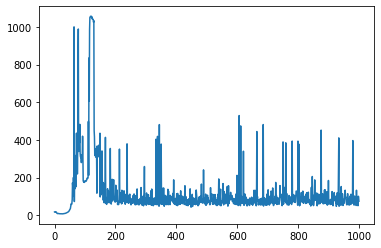

In [52]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(list_res)
plt.show()